# This notebook will provide a model able to predict bounding box in order to fed a CNN classification model then. The dataset used to do that can be found in Kaggle : https://www.kaggle.com/datasets/tannergi/chess-piece-detection

In [1]:
import os
import numpy as np
import PIL
import xml.etree.ElementTree as ET
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import struct
from sklearn.cluster import KMeans

import tensorflow as tf
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras import models
from keras.models import Model
from keras.layers import Input, Dense, GlobalAveragePooling2D, UpSampling2D, add, concatenate, Conv2D, Lambda, BatchNormalization, LeakyReLU, ZeroPadding2D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [2]:
classes = ['white-rook', 'white-knight', 'white-bishop', 'white-king', 'white-queen', 'white-pawn', 'black-rook', 'black-knight', 'black-bishop', 'black-king', 'black-queen', 'black-pawn']

In [3]:
def get_dataset_dicts(annotation_path, image_path, classes):
    dataset_dicts = []
    for filename in os.listdir(annotation_path):
        if filename != '.ipynb_checkpoints':
            record = {}
            root = ET.parse(os.path.join(annotation_path, filename)).getroot()
            record["file_name"] = os.path.join(image_path, root.find('filename').text)
            record["height"] = 2248
            record["width"] = 4000

            objs = []
            for member in root.findall('object'):
                obj = {
                  'bbox': [int(member[4][0].text), int(member[4][1].text), int(member[4][2].text), int(member[4][3].text)],
                  'category_id': classes.index(member[0].text),
                  "iscrowd": 0}
                objs.append(obj)
            record["annotations"] = objs
            dataset_dicts.append(record)
    return dataset_dicts

In [4]:
dataset = get_dataset_dicts('Dataset\\detection\\annotations', 'Dataset\\detection\\images', classes)

In [345]:
dataset[:5]

[{'file_name': 'Dataset\\detection\\images\\IMG_1989.JPG',
  'height': 2248,
  'width': 4000,
  'annotations': [{'bbox': [1780, 573, 2319, 1442],
    'category_id': 0,
    'iscrowd': 0}]},
 {'file_name': 'Dataset\\detection\\images\\IMG_1990.JPG',
  'height': 2248,
  'width': 4000,
  'annotations': [{'bbox': [1880, 1052, 2383, 1532],
    'category_id': 0,
    'iscrowd': 0}]},
 {'file_name': 'Dataset\\detection\\images\\IMG_1991.JPG',
  'height': 2248,
  'width': 4000,
  'annotations': [{'bbox': [1325, 1112, 1564, 1378],
    'category_id': 0,
    'iscrowd': 0}]},
 {'file_name': 'Dataset\\detection\\images\\IMG_1992.JPG',
  'height': 2248,
  'width': 4000,
  'annotations': [{'bbox': [1613, 342, 2001, 1098],
    'category_id': 1,
    'iscrowd': 0}]},
 {'file_name': 'Dataset\\detection\\images\\IMG_1993.JPG',
  'height': 2248,
  'width': 4000,
  'annotations': [{'bbox': [1795, 880, 2165, 1280],
    'category_id': 1,
    'iscrowd': 0}]}]

C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


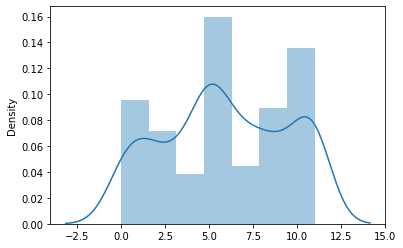

In [281]:
classification_ = np.array([piece['category_id'] for count in range(len(dataset)) for piece in dataset[count]['annotations']])
sns.distplot(classification_)
plt.show()

The dataset is relatively unbalanced

In [87]:
height = np.mean(np.array([dataset[count]['height'] for count in range(len(dataset))]))
width = np.mean(np.array([dataset[count]['width'] for count in range(len(dataset))]))

print(height, width)

2248.0 4000.0


All images have the same dimension. So we will scale dimension of bounding box to be between [0,1]

In [346]:
bounding_box=  np.array([piece['bbox'] for count in range(len(dataset)) for piece in dataset[count]['annotations']])

In [347]:
bounding_box_scaled = bounding_box /np.array([width, height ,width, height])

In [348]:
bounding_box_scaled[:5]

array([[0.445     , 0.25489324, 0.57975   , 0.64145907],
       [0.47      , 0.46797153, 0.59575   , 0.68149466],
       [0.33125   , 0.49466192, 0.391     , 0.61298932],
       [0.40325   , 0.15213523, 0.50025   , 0.48843416],
       [0.44875   , 0.39145907, 0.54125   , 0.56939502]])

In [349]:
bounding_box_scaled.shape

(398, 4)

In [119]:
print(np.min(bounding_box_scaled), np.max(bounding_box_scaled))

0.00044483985765124553 1.0


## Loading images

In [146]:
img = []
for file in dataset:
    temp_img = PIL.Image.open(file['file_name'])
    temp_img = temp_img.resize((224,224),PIL.Image.ANTIALIAS)
    img.append(np.array(temp_img))
img = np.array(img)

C:\Users\thoma\AppData\Local\Temp\ipykernel_2920\1486849621.py:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  temp_img = temp_img.resize((224,224),PIL.Image.ANTIALIAS)


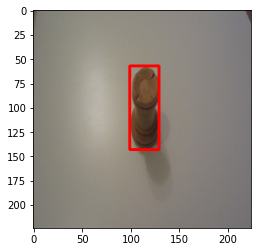

In [168]:
xmin,ymin,xmax,ymax = (bounding_box_scaled[0] * 224).astype(int)
plt.imshow(cv2.rectangle(img[0], (xmin,ymin), (xmax,ymax), (255,0,0), 2))

In [229]:
one_hot = OneHotEncoder(handle_unknown='ignore')
labels = np.array(classification_).reshape(-1,1)
one_hot.fit(labels)
one_hot_classification = one_hot.transform(labels).toarray()

In [231]:
X_train, X_test, bbs_train, bbs_test = train_test_split(img, bounding_box_scaled, test_size=0.2, random_state=0)
classif_train, classif_test, _, _ = train_test_split(one_hot_classification, one_hot_classification, test_size=0.2, random_state=0)

C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

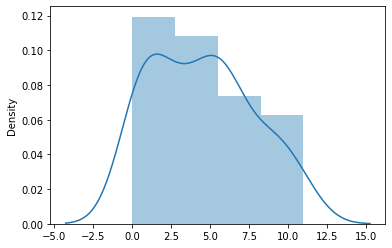

In [259]:
sns.distplot(np.argmax(classif_train, axis = 1))

C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

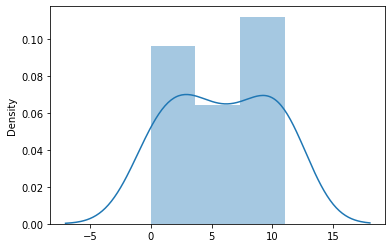

In [260]:
sns.distplot(np.argmax(classif_test, axis = 1))

In [170]:
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

In [183]:
IMG_SHAPE = X_train.shape[1:]
mobileNet = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    alpha=1.0,
    include_top=False,
    weights="imagenet"
)

In [184]:
mobileNet.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [203]:
input_ = Input(shape=IMG_SHAPE)
feature_extraction = mobileNet(input_)
pooling_layer = GlobalAveragePooling2D()(feature_extraction)
bounding_box_detection = Dense(4, 'sigmoid')(pooling_layer)
classification = Dense(len(classes), 'softmax')(pooling_layer)

model = Model(input_, [bounding_box_detection, classification])

In [206]:
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in model.layers[1].layers[:fine_tune_at]:
    layer.trainable = False

In [226]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 mobilenetv2_1.00_224 (Function  (None, 7, 7, 1280)  2257984     ['input_8[0][0]']                
 al)                                                                                              
                                                                                                  
 global_average_pooling2d_6 (Gl  (None, 1280)        0           ['mobilenetv2_1.00_224[6][0]']   
 obalAveragePooling2D)                                                                      

In [234]:
model.compile(optimizer = "adam", loss = ["mse", "CategoricalCrossentropy"]) 

In [235]:
classif_train.shape

(64, 12)

In [236]:
model.fit(X_train, [bbs_train, classif_train], epochs = 50, verbose=1, shuffle=True)

Epoch 1/50
2/2 [==============================] - 3s 556ms/step - loss: 2.5320 - dense_7_loss: 0.0472 - dense_8_loss: 2.4848
Epoch 2/50
2/2 [==============================] - 1s 556ms/step - loss: 1.5510 - dense_7_loss: 0.0354 - dense_8_loss: 1.5156
Epoch 3/50
2/2 [==============================] - 1s 552ms/step - loss: 0.7980 - dense_7_loss: 0.0296 - dense_8_loss: 0.7685
Epoch 4/50
2/2 [==============================] - 1s 562ms/step - loss: 0.3162 - dense_7_loss: 0.0272 - dense_8_loss: 0.2890
Epoch 5/50
2/2 [==============================] - 1s 554ms/step - loss: 0.1065 - dense_7_loss: 0.0241 - dense_8_loss: 0.0824
Epoch 6/50
2/2 [==============================] - 1s 568ms/step - loss: 0.0385 - dense_7_loss: 0.0168 - dense_8_loss: 0.0217
Epoch 7/50
2/2 [==============================] - 1s 635ms/step - loss: 0.0208 - dense_7_loss: 0.0136 - dense_8_loss: 0.0072
Epoch 8/50
2/2 [==============================] - 1s 565ms/step - loss: 0.0111 - dense_7_loss: 0.0078 - dense_8_loss: 0.0033


In [238]:
model.history.history.keys()

dict_keys(['loss', 'dense_7_loss', 'dense_8_loss'])

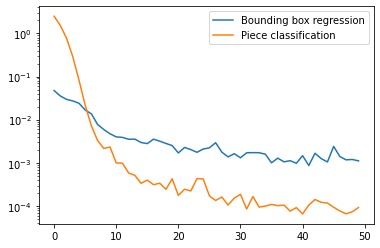

In [240]:
plt.plot(model.history.history['dense_7_loss'])
plt.plot(model.history.history['dense_8_loss'])
plt.yscale("log")

plt.legend(["Bounding box regression", "Piece classification"])

In [264]:
y_pred = model.predict(X_train)      

2/2 [==============================] - 1s 444ms/step


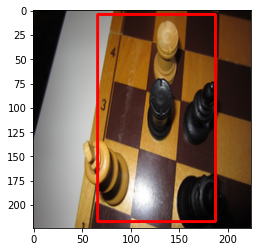

In [267]:
xmin,ymin,xmax,ymax = (y_pred[0][0] * 224).astype(int)
plt.imshow(cv2.rectangle(X_train[0], (xmin,ymin), (xmax,ymax), (255,0,0), 2))

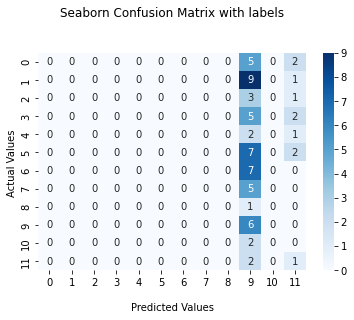

In [263]:
y_pred_classification = np.argmax(y_pred[1], axis = 1)

M = confusion_matrix(np.argmax(classif_train, axis = 1), y_pred_classification)
ax = sns.heatmap(M, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

## Display the visualization of the Confusion Matrix.
plt.show()

In [241]:
y_pred = model.predict(X_test)       

1/1 [==============================] - 1s 720ms/step


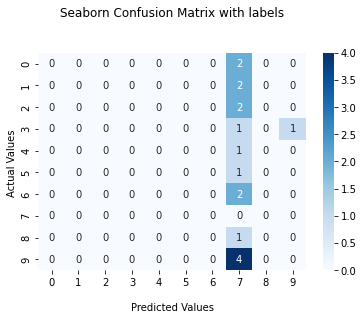

In [248]:
y_pred_classification = np.argmax(y_pred[1], axis = 1)

M = confusion_matrix(np.argmax(classif_test, axis = 1), y_pred_classification)
ax = sns.heatmap(M, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

## Display the visualization of the Confusion Matrix.
plt.show()